In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

In [0]:
#!conda update matplotlib

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [0]:
####COLABORATORY
#********correr 1 UNICA VEZ ******************
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

<h3>COLABORATORY</h3>
<p>
ver archivos de la carpeta de la que quiero cargar archivos de entrada#tengo que tomar de la url el numero que se encuentra despues de<br/>
  https://drive.google.com/drive/folders/<b>**1Sq2ogO0TqSJJHITbql8RwnfnYpk50Im</b>i?ogsrc=32**
  </p>

In [16]:
####COLABORATORY

file_list = drive.ListFile({'q': "'1sffZi4hkGFPBsaBycwtZZxZOX1eoKJ6H' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: banmedica2018.csv, id: 15F_w8DsWZ06id9mNaMs2pbX0kc8_ZVMf
title: banmedica2.csv, id: 1C2tjrBFMdMvcKX1Arf-MCBtGvWjTIwls
title: TH_CONSULTA_MEDICA_20181002_2.csv, id: 16ugSgqn_gixAiFi6hh2yj-PKvTSZ7Zi0
title: TH_CONSULTA_MEDICA1.csv, id: 1diRyA99hMMlnNSbFTFGp83LaVK3epuha
title: mas_10_horas.csv, id: 1HBd0u9Ve3CDGUiiyunkLwZiiXz3wBYra
title: DM_PACIENTE.csv, id: 1j6FsFp8wpy4vpMmBMxuzztioamgCIu4w
title: DM_HORARIO.csv, id: 1kW71YfBWwRR7K8y1rx_D14EFhCPPh4XG
title: TH_CONSULTA_MEDICA.csv, id: 1upCH4ag-eUF-Om8NmPH2vACOqu7P6mlo
title: DM_ESPECIALIDAD.csv, id: 1Ga42LpLg0qar_wAGHQHaEjKAOx-tjwze
title: DM_BOX.csv, id: 1hYF0LCJ4YbWoeC9LYKeY57pOPPMEfk8A


In [0]:
consulta = drive.CreateFile({'id': '1C2tjrBFMdMvcKX1Arf-MCBtGvWjTIwls'})
consulta.GetContentFile('banmedica2.csv')




In [8]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sys import platform
from keras.utils import to_categorical

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

if platform =='win32':
    db_path= 'C:/Users/mv_ra/Documents/hexagon/tensor_flow/Banmedica/BBDD/'
elif platform == 'linux' or platform == 'linux2':
    #db_path= '~/Documentos/hexagon/tensorFlow/BBDD/' #coco3
    db_path='/home/victoria/Documents/tensorFlow/BBDD/' #hexagon linux
    #db_path= '/home/victoria/Documentos/hexagon/tensorFlow/'
    #db_path='./' #colaboratory
    
df = pd.read_csv( db_path+ 'banmedica2.csv', sep=';', 
                  encoding='latin-1', parse_dates= True, dayfirst=True)

#especializaciones = pd.read_csv( db_path+ 'BBDD/DM_ESPECIALIDAD.csv', sep=';',encoding='latin-1' )
  


#'RSCM_IND_RESERVA_VIGENTE',
feature_list=['se_presento','RSCM_PCNT_ETARIO','RSCM_CNAL_RESERVA', 'dayfoweek_reserva',
              'PCNT_ESTADO_CIVIL','RSCM_PCNT_NUEVO','PCNT_SEXO','ESPC_NOMBRE', 'ESPC_NOMBRE_group',
              'dias_diff_reserva_cita','dias_diff_reserva_cita_cat','month', 'hour',
              'dayfoweek_reserva','morning','RSCM_PCNT_NUEVO',
              'se_presento_L1','espera_ra_mas_45_m_L1', 'dias_diff_reserva_anul_group_L1',
              'se_presento_L2','se_presento_L3', 'CANT_TURNOS_PREVIOS_L2_R_cat', 
               'CANT_TURNOS_PREVIOS_L3_R_cat']
df1=df[feature_list].copy()
df1.se_presento = to_categorical(df1.se_presento)
df1['solicita_turno_mas7'] =  np.where(df1['dias_diff_reserva_cita'] >7, 1, 0)
df1=df1.drop('dias_diff_reserva_cita', axis=1)



#df1['ESPC_NOMBRE'] = df1['ESPC_NOMBRE'].cat.add_categories(especializaciones.ESPC_NOMBRE)  


list_features= ['RSCM_PCNT_ETARIO','PCNT_SEXO', 'PCNT_ESTADO_CIVIL','RSCM_PCNT_NUEVO', 
                'ESPC_NOMBRE','ESPC_NOMBRE_group','RSCM_CNAL_RESERVA', 
                'month', 'hour','dayfoweek_reserva',
                'dias_diff_reserva_cita_cat', 
                'se_presento_L1','espera_ra_mas_45_m_L1', 'dias_diff_reserva_anul_group_L1',
                'se_presento_L2','se_presento_L3', 'CANT_TURNOS_PREVIOS_L2_R_cat', 
                'CANT_TURNOS_PREVIOS_L3_R_cat']
#,'month', 'hour','dayfoweek_reserva','morning']
#,'se_presento_L1', 'se_presento_L2','se_presento_L3']

for col in list_features:
    df1=pd.concat([df1, pd.get_dummies(df[col],prefix=col , prefix_sep='_')], axis=1)

df1 = df1.loc[:,~df1.columns.duplicated()]

#del list_features

df1=df1.drop(list_features, axis=1)

se_presento = encode_text_index(df1,'se_presento')
num_classes = len(se_presento)

del df

In [9]:
# Create x & y for training

# Create the x-side (feature vectors) of the training
x, y = to_xy(df1,'se_presento')
    
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.30, random_state=42) 

#test_x['dayfoweek_reserva']=test_x['dayfoweek_reserva'].astype(str)


/home/victoria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [11]:
#solo guardo las dos primeras filas para poder ver cuales eran los features del modelo
df1=df1.head(2)

model = Sequential()
model.add(Dense(300, input_dim=x.shape[1], activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=1000)
model.load_weights('best_weights.hdf5') # load weights from best model

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_compare = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_compare, pred)
print("Final accuracy: {}".format(score))

Epoch 00007: early stopping
Final accuracy: 0.7108114502010883


Confusion matrix, without normalization
[[16653   949]
 [ 8750  1166]]
Normalized confusion matrix
[[0.95 0.05]
 [0.88 0.12]]


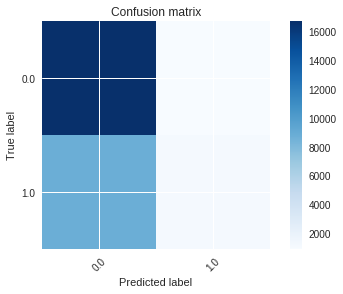

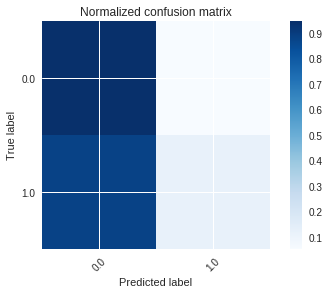

In [13]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_compare, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, se_presento)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, se_presento, title='Normalized confusion matrix')

plt.show()

array([0, 1])

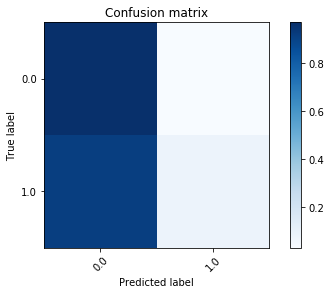

In [0]:
#cm_normalized
#se_presento
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(se_presento))
plt.xticks(tick_marks, se_presento, rotation=45)
plt.yticks(tick_marks, se_presento)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks

In [0]:
pred

array([1, 1, 1, ..., 1, 1, 0])

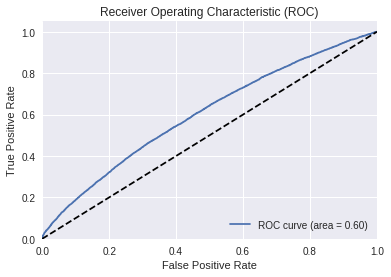

In [14]:
pred = model.predict(x_test)
pred = pred[:,1] # Only positive cases
plot_roc(pred,y_compare)

<h2>Para Test</h2>

In [0]:
consulta = drive.CreateFile({'id': '15F_w8DsWZ06id9mNaMs2pbX0kc8_ZVMf'})
consulta.GetContentFile('banmedica2018.csv')


In [0]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sys import platform
from keras.utils import to_categorical

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

if platform =='win32':
    db_path= 'C:/Users/mv_ra/Documents/hexagon/tensor_flow/Banmedica/BBDD/'
elif platform == 'linux' or platform == 'linux2':
    #db_path= '~/Documentos/hexagon/tensorFlow/BBDD/' #coco3
    #db_path='/home/victoria/Documents/tensorFlow/' #heagon linux
    #db_path= '/home/victoria/Documentos/hexagon/tensorFlow/'
    db_path='./' #colaboratory
    
df = pd.read_csv( db_path+ 'banmedica2018.csv', sep=';', 
                  encoding='latin-1', parse_dates= True, dayfirst=True)

#'RSCM_IND_RESERVA_VIGENTE',
feature_list=['se_presento','RSCM_PCNT_ETARIO','RSCM_CNAL_RESERVA', 'dayfoweek_reserva','PCNT_ESTADO_CIVIL','RSCM_PCNT_NUEVO','PCNT_SEXO','ESPC_NOMBRE','dias_diff_reserva_cita','dias_diff_reserva_cita_cat','month', 'hour','dayfoweek_reserva','morning','se_presento_L1','RSCM_PCNT_NUEVO','se_presento_L2','se_presento_L3']
df_test=df[feature_list].copy()
df_test.se_presento = to_categorical(df_test.se_presento)
df_test['solicita_turno_mas7'] =  np.where(df_test['dias_diff_reserva_cita'] >7, 1, 0)
df_test=df_test.drop('dias_diff_reserva_cita', axis=1)



#df1['ESPC_NOMBRE'] = df1['ESPC_NOMBRE'].cat.add_categories(especializaciones.ESPC_NOMBRE)  
#,'RSCM_IND_RESERVA_VIGENTE'
list_features= ['RSCM_PCNT_ETARIO','PCNT_SEXO', 'ESPC_NOMBRE','RSCM_CNAL_RESERVA', 'month', 'hour','dayfoweek_reserva','PCNT_ESTADO_CIVIL','RSCM_PCNT_NUEVO', 'dias_diff_reserva_cita_cat']
#,'month', 'hour','dayfoweek_reserva','morning']
#,'se_presento_L1', 'se_presento_L2','se_presento_L3']

for col in list_features:
    df_test=pd.concat([df_test, pd.get_dummies(df[col],prefix=col , prefix_sep='_')], axis=1)

df_test = df_test.loc[:,~df_test.columns.duplicated()]

#del list_features

df_test=df_test.drop(list_features, axis=1)

se_presento = encode_text_index(df_test,'se_presento')
num_classes = len(se_presento)




In [0]:
#dado que el algoritmo entrena con columnas dummies las que no se encuentran debemos agregarlas
#las filas que tienen columnas nuevas no debemos eliminarlas

missing_cols = set( df1.columns ) - set( df_test.columns )
eliminar_rows = set( df_test.columns ) - set( df1.columns )
missing_cols
#missing_cols2  {'ESPC_NOMBRE_DIAGNOSTICO NEUROPSICOLOGICO', 'ESPC_NOMBRE_NEUROPSICOLOGIA INFANTOJUVENIL', 'ESPC_NOMBRE_RETINA'}
#missing_cols {'ESPC_NOMBRE_CIRUGÍA PLASTICA Y REPARADORA', 'ESPC_NOMBRE_PEDIATRIA POLI DOCENTE', 'ESPC_NOMBRE_PSICODIAGNOSTICO ADULTOS', 'ESPC_NOMBRE_PSICÓLOGA CLÍNICA'}


# Add a missing column in test set with default value equal to 0
df_missing_cat = pd.DataFrame({'cat': list(missing_cols)})

dummies = pd.get_dummies(df_missing_cat, prefix='', prefix_sep='')

for i in range(len(df_test)):
  dummies.loc[i] = [0 for n in range(len(missing_cols))]
  


In [0]:
#missing_cols

#dummies.loc[68798] = [0 for n in range(len(missing_cols))]
#dummies.shape #(68799, 30)
#df_test.shape
#df1.shape


(68799, 30)

In [0]:
#df_test[eliminar_rows = 1]

#df_test.loc[lambda df_test: eliminar_rows, :]
  

#type(eliminar_rows)

#str= 
#eliminar_rows[0]
if len(eliminar_rows) > 0:
    eliminados = pd.DataFrame()

    for c in eliminar_rows:
      eliminados= eliminados.append(df_test[df_test[c]==1])
      #df_test=df_test.drop(df_test[df_test[c]==1], axis=1)
  
    df_test[eliminados]

In [0]:
#eliminados.head(2)
#len(eliminar_rows)
#print sets
for s in eliminar_rows:
    print(", ".join(str(e) for e in s))

#*******************************************************************
#dummies=dummies.drop(eliminar_rows, axis=1)
#eliminados[['ESPC_NOMBRE_DIAGNOSTICO NEUROPSICOLOGICO','ESPC_NOMBRE_NEUROPSICOLOGIA INFANTOJUVENIL','ESPC_NOMBRE_RETINA']]

#eliminados
#df_test[]
    
#list(eliminados)


#result = pd.concat([df_test, dummies], axis=1)#, sort=False

#df_test['ESPC_NOMBRE_DIAGNOSTICO NEUROPSICOLOGICO'==1]

#list(eliminar_rows)

#df1.shape
#df_test.shape
#dummies

0

In [21]:
#print (dummies.shape[1] + df_test.shape[1], df1.shape[1])
#len(missing_cols)-1

result = pd.concat([df_test.reset_index(), dummies], axis=1)
#result.shape
result=result.set_index('index')

cols = df1.columns.tolist()
df_test = result[cols]
df_test.shape

(47273, 139)

In [0]:
# Create x & y for training

# Create the x-side (feature vectors) of the training
x2, y2 = to_xy(df_test,'se_presento')
    
#FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [23]:

# Measure accuracy
pred2 = model.predict(x2)
pred2 = np.argmax(pred2,axis=1)
y_compare2 = np.argmax(y2,axis=1)
score = metrics.accuracy_score(y_compare2, pred2)
print("Final accuracy: {}".format(score))

Final accuracy: 0.663317327015421


Confusion matrix, without normalization
[[29521  1817]
 [14099  1836]]
Normalized confusion matrix
[[0.94 0.06]
 [0.88 0.12]]


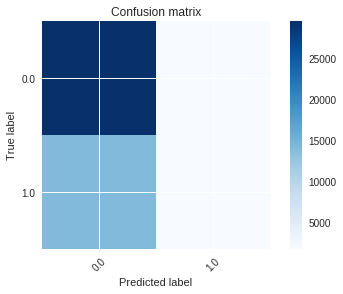

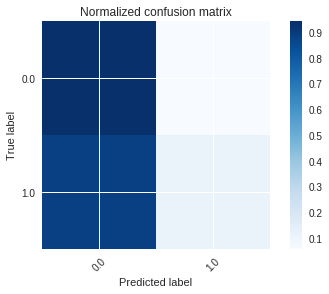

In [24]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_compare2, pred2)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, se_presento)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, se_presento, title='Normalized confusion matrix')

plt.show()

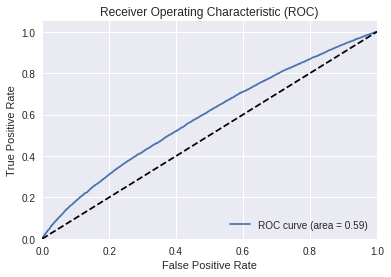

In [25]:
pred2 = model.predict(x2)
pred2 = pred2[:,1] # Only positive cases
plot_roc(pred2,y_compare2)